# Playing with model described in https://arxiv.org/abs/1610.02415 
# Generating aspirin neighbours

In [1]:
import pandas as pd
import h5py
import numpy as np
from molecules.model import MoleculeVAE
from molecules.utils import one_hot_array, one_hot_index, decode_smiles_from_indexes

# number of dimensions to represent the molecules
# as the model was trained with this number, any operation made with the model must share the dimensions.
latent_dim = 292

# data used to train the model
data_used = 'data/chembl_22_processed.h5'

# trained_model 0.95 validation accuracy
# trained with 80% of ALL chembl molecules, validated on the other 20.
trained_model = 'models_saved/chembl_22_model_095.h5'

aspirin_smiles = 'CC(=O)Oc1ccccc1C(=O)O'

Using TensorFlow backend.


# Load model

In [2]:
# load charset from data used to train the model
# we need to use the charset of ALL training dataset, not only charset from our new input molecules
h5f = h5py.File(data_used, 'r')
charset =  list(h5f['charset'][:])
h5f.close()
model = MoleculeVAE()
model.load(charset, trained_model, latent_rep_size = latent_dim)

# Encode aspirin

In [3]:
a = list(aspirin_smiles.ljust(120))
aspirin_preprocessed = np.array([map(lambda x: one_hot_array(x, len(charset)), one_hot_index(a, charset))])
aspirin_latent = model.encoder.predict(aspirin_preprocessed)

# Generate 10k random latent mol representations with mean==aspirin, stdev==0.1

In [4]:
stdev = 0.1
latent_mols = stdev * np.random.randn(10000, latent_dim) + aspirin_latent

# Decode them

In [5]:
decoded_molecules = []
for m in latent_mols:
    decoded = model.decoder.predict(m.reshape(1, latent_dim)).argmax(axis=2)[0]
    decoded = decode_smiles_from_indexes(decoded, charset)
    decoded_molecules.append(decoded)

# Validate using RDKit

In [6]:
from rdkit import Chem
from rdkit import RDLogger

# remove warnings and errors from notebook (lots of them due non valid molecule generation)
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []
for smiles in decoded_molecules:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

# Check how many of them match with unichem 

In [7]:
import requests

url = 'https://www.ebi.ac.uk/unichem/rest/inchikey/{}'

inchi_keys = [Chem.InchiToInchiKey(Chem.MolToInchi(m)) for m in working_mols]
u, indices = np.unique(inchi_keys, return_index=True)

unique_mols = [[working_mols[i], inchi_keys[i]] for i in indices]

in_unichem = []
for um in unique_mols:
    res = requests.get(url.format(um[1]))
    if res.status_code == 200:
        in_unichem.append([um[0], res.json()])

not_in_chembl = filter(lambda mol: 1 not in [int(res['src_id']) for res in mol[1]], in_unichem)

print "rdkit valid mols:", len(working_mols)
print "unique molecules:", len(unique_mols)
print "found in unichem:", len(in_unichem)
print "not in chembl:", len(not_in_chembl)

rdkit valid mols: 1767
unique molecules: 1087
found in unichem: 172
not in chembl: 163


# Print mols found in unichem and not in chembl

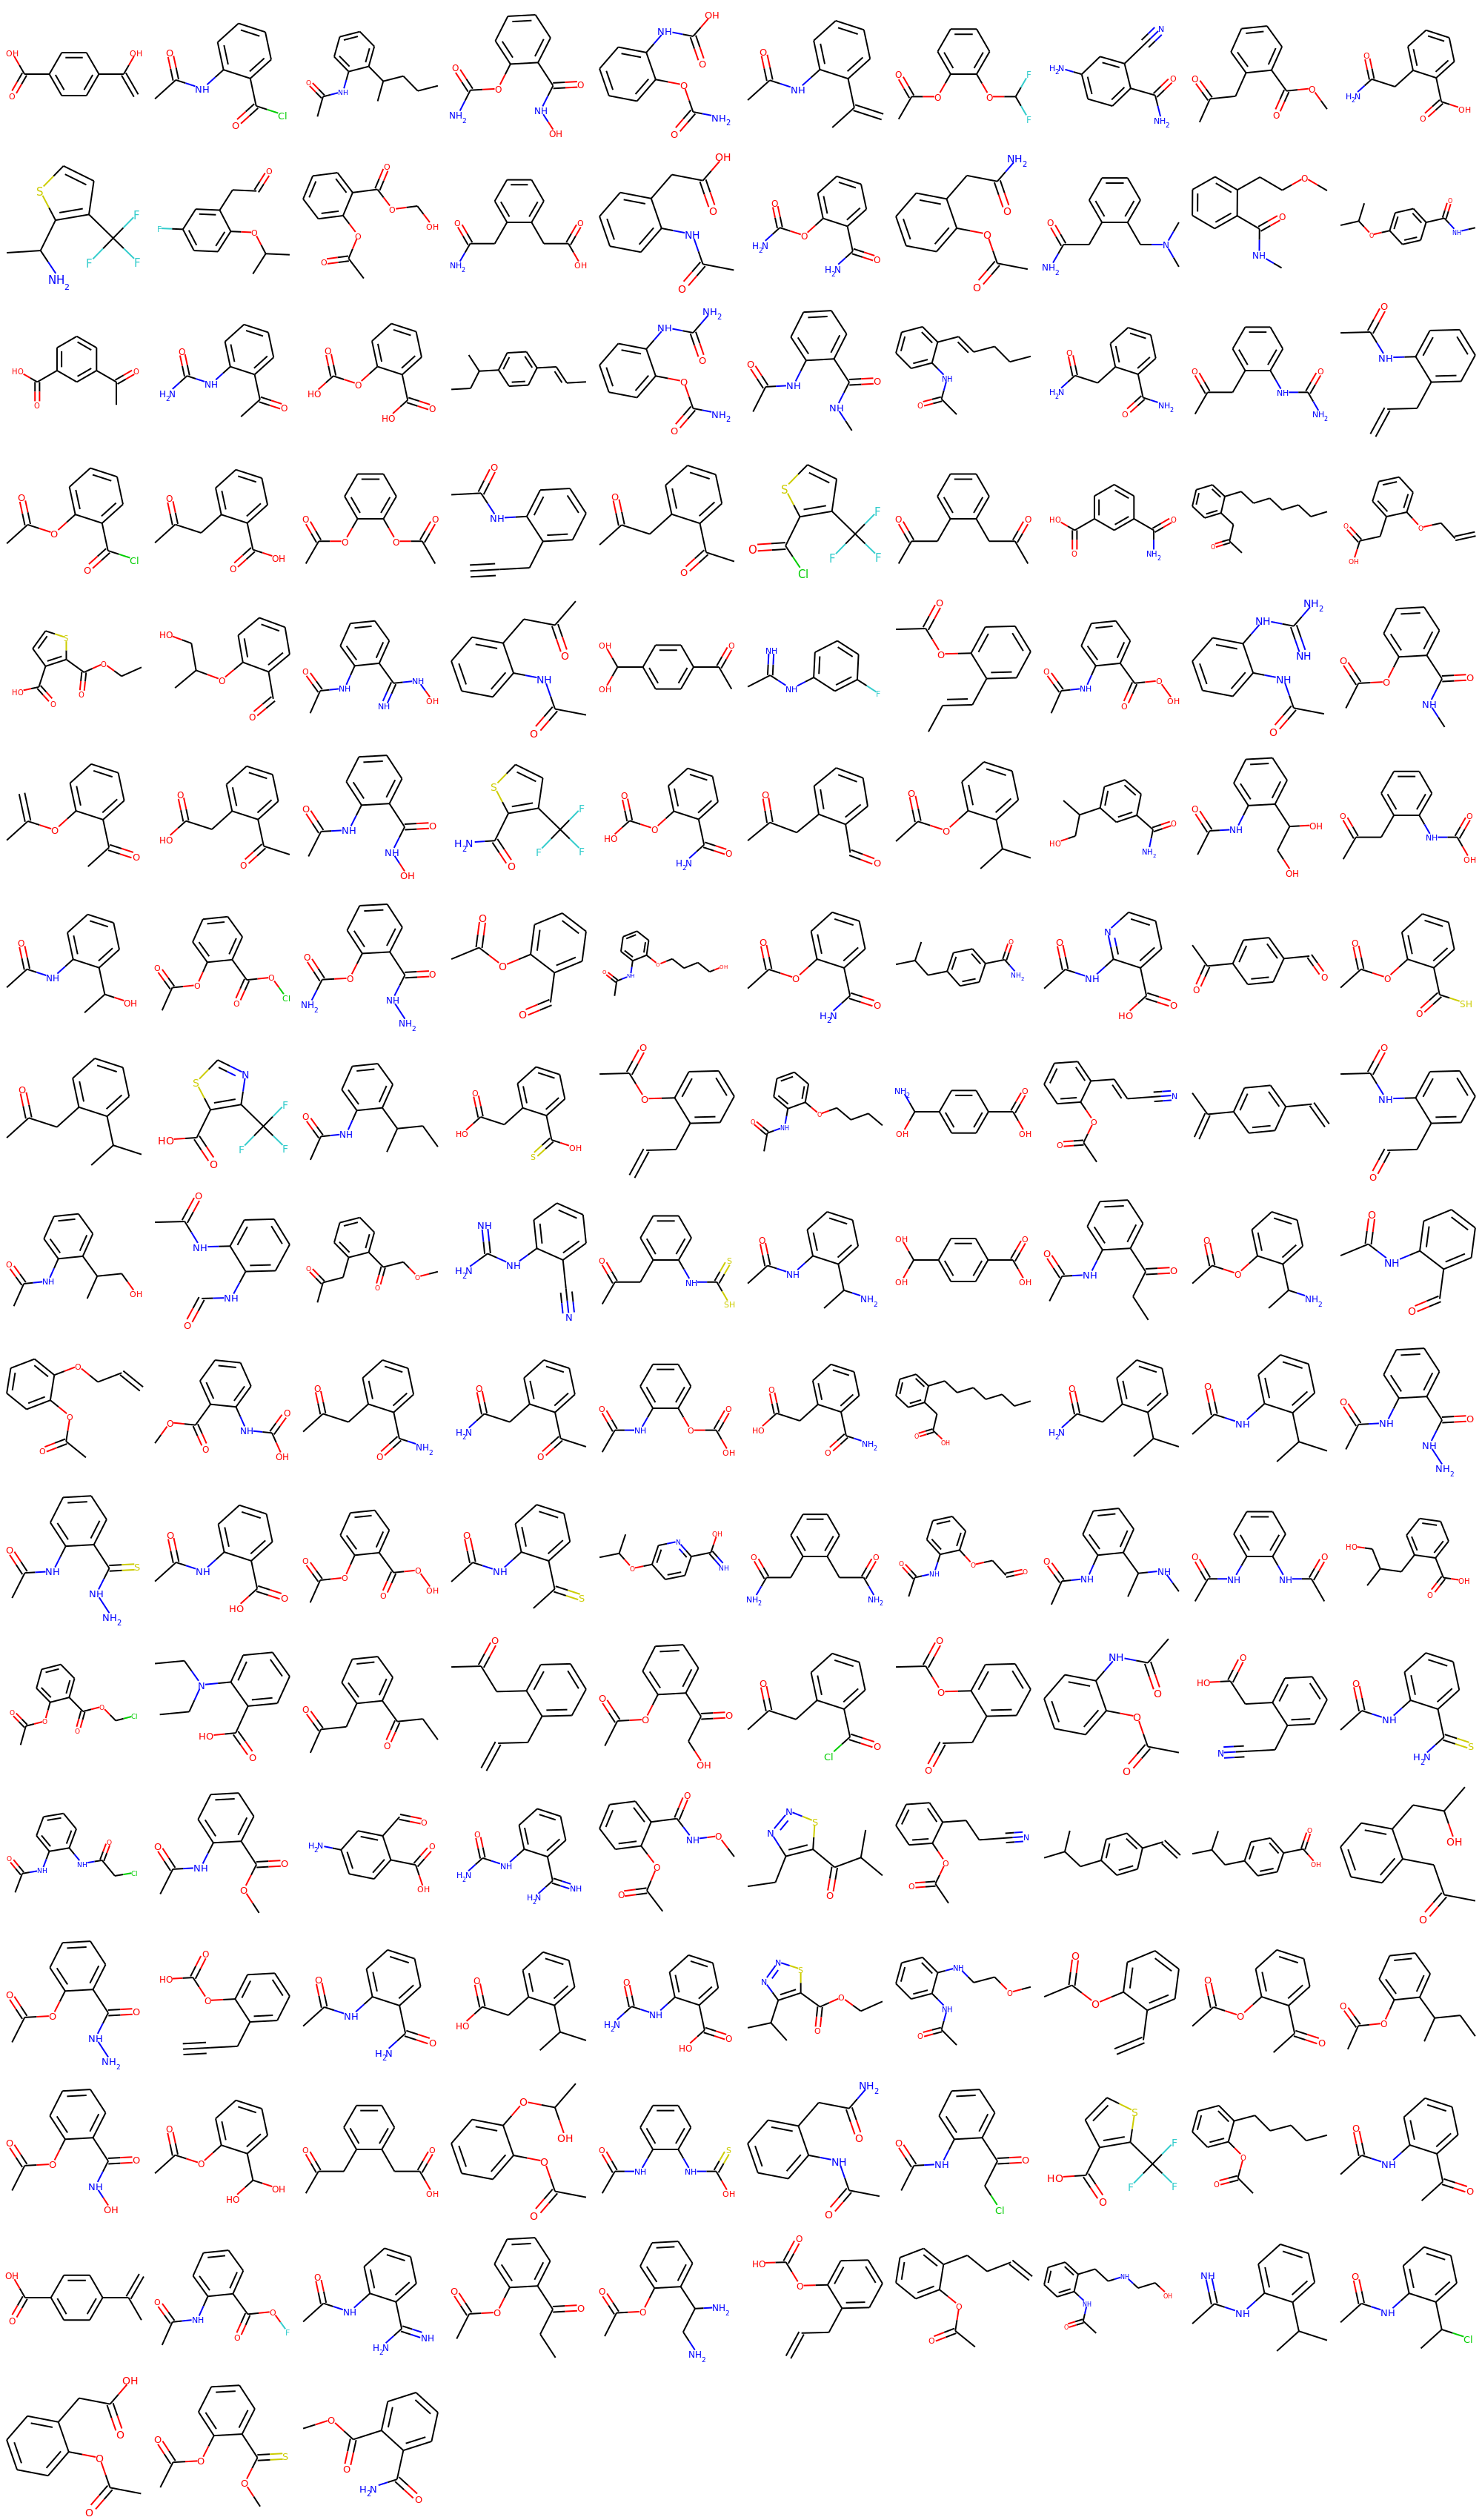

In [8]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Draw.MolsToGridImage([mol[0] for mol in not_in_chembl], molsPerRow=10)